In [26]:
import h5py
import pandas as pd
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')


X = X_cal.values
Y = Y_cal.values

X.shape

(936, 219)

In [27]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import numpy as np

lv_nums = 9
n_pred_obs = 5

windows = [20, 40, 60, 80, 100]
R2_mean = np.zeros((len(windows),lv_nums))
Q2_mean = np.zeros((len(windows),lv_nums))
coefs = np.zeros((len(windows),lv_nums, X.shape[1]))
for ii,window_size in enumerate(windows):
    
    N_seg = X.shape[0]-window_size-n_pred_obs
    for latent_variables in range(1,lv_nums+1):
        model = make_pipeline(StandardScaler(), PLSRegression(n_components=latent_variables))
        current_time = window_size
        R2 = []
        Q2 = []
        for seg in range(N_seg):
            # X_seg_cal = X[current_time-window_size:current_time,:]
            # X_seg_test = X[current_time:current_time+lv_nums,:]
            # Y_seg_cal = Y[current_time-window_size:current_time]
            # Y_seg_test = Y[current_time:current_time+lv_nums]
            X_seg_cal = X[ seg:seg+window_size, : ] 
            X_seg_test = X[ seg+window_size:seg+window_size+n_pred_obs, : ]
            Y_seg_cal = Y[ seg:seg+window_size ]
            Y_seg_test = Y[ seg+window_size:seg+window_size+n_pred_obs ]    
            
            model.fit(X_seg_cal, Y_seg_cal)

            coefs[ii,latent_variables-1,:] = model.named_steps['plsregression'].coef_

            Y_cal_pred = model.predict(X_seg_cal)
            Y_test_pred = model.predict(X_seg_test)
            
            # Calculate R2
            TSSRes  = np.sum( ( Y_seg_cal - np.mean(Y_seg_cal) )**2 );
            RSSRes  = np.sum( ( Y_seg_cal - Y_cal_pred )**2 );
            R2.append( 1 - RSSRes / TSSRes )

            # Calculate Q2
            pRESS = np.sum( ( Y_seg_test - Y_test_pred )**2 )
            
            Q2_val = 1 - pRESS / TSSRes
            
            if abs( Q2_val ) < 1:
                Q2.append(Q2_val)

            # R2.append(r2_score(Y_seg_cal,Y_cal_pred))
            # Q2.append(r2_score(Y_seg_test,Y_test_pred))

            # current_time += 1
            

        R2_mean[ii,latent_variables-1] = np.mean(R2)
        Q2_mean[ii,latent_variables-1] = np.mean(Q2)







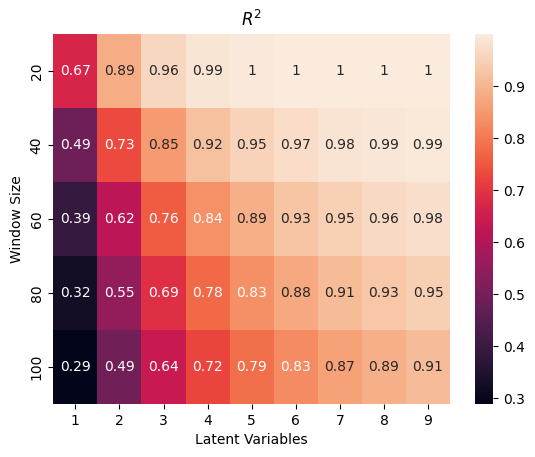

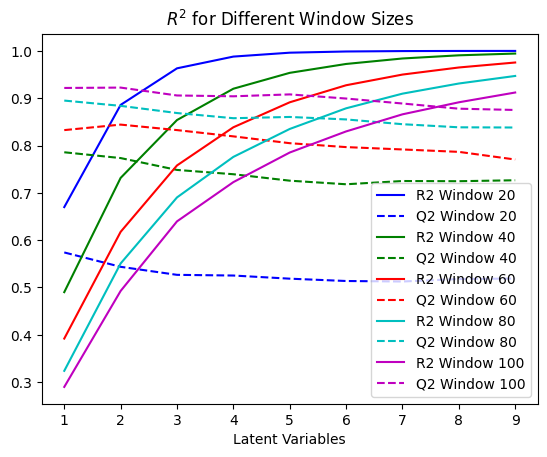

array([[0.57393672, 0.54358335, 0.52660371, 0.52513301, 0.51850142,
        0.51357516, 0.51249087, 0.51776641, 0.51876521],
       [0.78571485, 0.77345999, 0.74839442, 0.73929311, 0.72566544,
        0.71808888, 0.72494462, 0.72453541, 0.72655323],
       [0.83257669, 0.84419945, 0.83260408, 0.81933476, 0.80491241,
        0.79665417, 0.79166373, 0.78659034, 0.77040547],
       [0.89499264, 0.88385584, 0.86866172, 0.85773008, 0.8603786 ,
        0.85514299, 0.84506859, 0.8384872 , 0.83806051],
       [0.92167931, 0.92245488, 0.90579572, 0.90405611, 0.90806356,
        0.89931361, 0.88881299, 0.87786602, 0.8751453 ]])

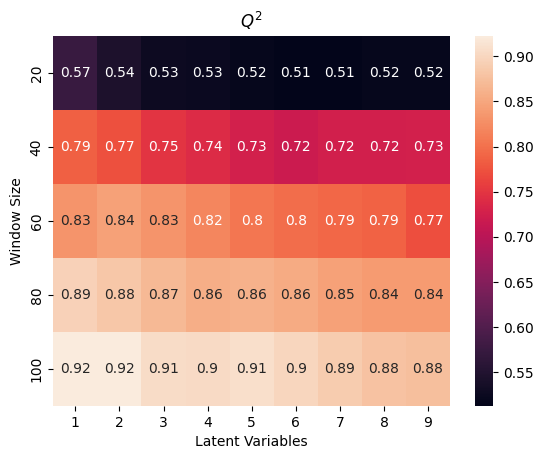

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_R2 = plt.figure()
sns.heatmap(R2_mean, annot=True, xticklabels=range(1,lv_nums+1), yticklabels=windows)
plt.ylabel('Window Size')
plt.xlabel('Latent Variables')
plt.title(r'$R^2$')

plt.figure()
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(R2_mean.shape[0]):
    plt.plot(range(1, lv_nums + 1), R2_mean[i, :], label=f'R2 Window {windows[i]}', color=colors[i])
    plt.plot(range(1, lv_nums + 1), Q2_mean[i, :], label=f'Q2 Window {windows[i]}', linestyle='--', color=colors[i])
plt.xlabel('Latent Variables')
# plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ for Different Window Sizes')
plt.legend()
plt.show()

heatmap_Q2 = plt.figure()
sns.heatmap(Q2_mean, annot=True, xticklabels=range(1,lv_nums+1), yticklabels=windows)
plt.ylabel('Window Size')
plt.xlabel('Latent Variables')
plt.title(r'$Q^2$')
# plt.plot(R2_mean.T)
# plt.plot(Q2_mean[0:,:2].T)
# plt.ylim(-10,1.1)

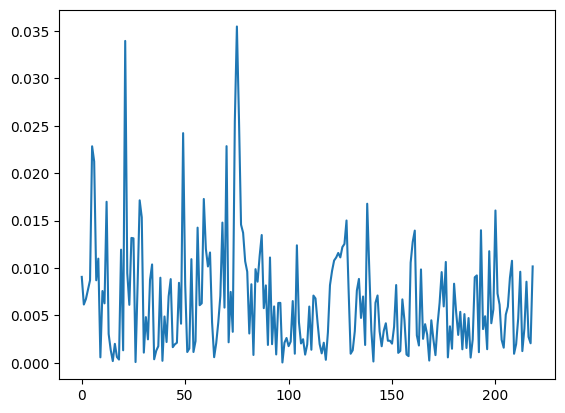

In [29]:

save_variables = False

plt.plot(abs(coefs[:,:5,:].mean(axis=(0,1))))

coef_abs = abs(coefs[:,:5,:].mean(axis=(0,1)))

N_half = int(X.shape[1]/2)

variables = np.argsort(coef_abs)[:N_half]

if save_variables:
    np.save('variables.npy',variables)